<a href="https://colab.research.google.com/github/der-himmel/obr-iz/blob/main/obr_iz_pz3_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка нужных зависимостей

In [86]:
!pip install opencv-python

!pip install numpy

!pip install matplotlib

# Импортируем библиотеки

In [87]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import io

In [88]:
image_height = 150
image_width = 150
dpi = 100

In [121]:
scale_factor = 90.0
scale_factor_low = 0.75

In [90]:
urls = [
    # f"https://evivid.ru/vk/img.php?url=https%3A%2F%2Fsun9-40.userapi.com%2Fimpg%2FCNGYtv5mZs4rONGMJx0crZ6-ajN_8sbPFP93wA%2FONDINN4x9aQ.jpg%3Fsize%3D429x604%26quality%3D96%26sign%3D701e7d60fa1fea0d6207e0a422c9d7eb%26c_uniq_tag%3DZESB4zRepXZuywLbaczntiMWkgX5Uiovn25WomRgztY%26type%3Dalbum",
    f"https://cdn.frankerfacez.com/emoticon/391932/4"
    ]

In [91]:
images = list()

for url in urls:
    image = io.imread(url)
    images.append(image)

In [116]:
def generate_noise_img(width: int, height: int) -> np.ndarray:
    noise_image = np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)
    return noise_image

noise_img = generate_noise_img(width=4, height=4)

In [93]:
def show_image(image: np.ndarray, dpi: int) -> None:
    image_height, image_width, _ = image.shape
    plt.figure(
        figsize=(
            image_width / float(dpi),
            image_height / float(dpi)
        )
    )
    plt.imshow(image)
    plt.axis('off')
    plt.show()

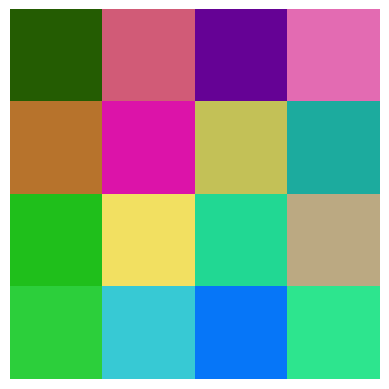

In [117]:
# img = images[0]
# show_image(img, dpi)

img = noise_img
plt.imshow(img)
plt.axis('off')
plt.show()

## Ближайшие соседи (Neares Neighbour)

In [95]:
def nearest_neighbour_interpolation(image: np.ndarray, scale_factor: float) -> np.ndarray:
    original_height, original_width, channels = image.shape
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)
    resized = np.zeros((new_height, new_width, channels), dtype=image.dtype)

    height_ratio = original_height / new_height
    width_ratio = original_width / new_width

    for i in range(new_height):
        for j in range(new_width):
            original_x = int(j * width_ratio)
            original_y = int(i * height_ratio)
            resized[i, j] = image[original_y, original_x]

    return resized

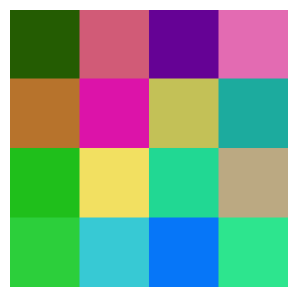

In [122]:
nearest_resized = nearest_neighbour_interpolation(img, scale_factor)
nearest_resized_low = nearest_neighbour_interpolation(img, scale_factor_low)

show_image(img, dpi)
show_image(nearest_resized, dpi)

## Билинейная интерполяция (Bilinear interpolation)

In [97]:
def bilinear_interpolation(image: np.ndarray, scale_factor: float) -> np.ndarray:
    original_height, original_width, channels = image.shape
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)
    resized = np.zeros((new_height, new_width, channels), dtype=image.dtype)
    height_ratio = original_height / new_height
    width_ratio = original_width / new_width

    for i in range(new_height):
        for j in range(new_width):
            x = j * width_ratio
            y = i * height_ratio

            x_floor = int(x)
            y_floor = int(y)
            x_ceil = min(x_floor + 1, original_width - 1)
            y_ceil = min(y_floor + 1, original_height - 1)

            a = image[y_floor, x_floor]
            b = image[y_floor, x_ceil]
            c = image[y_ceil, x_floor]
            d = image[y_ceil, x_ceil]

            x_diff = x - x_floor
            y_diff = y - y_floor

            new_value = (a * (1 - x_diff) * (1 - y_diff) +
                         b * x_diff * (1 - y_diff) +
                         c * y_diff * (1 - x_diff) +
                         d * x_diff * y_diff)

            resized[i, j] = new_value

    return resized

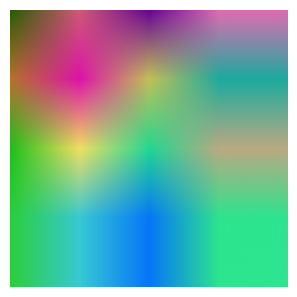

In [123]:
bilinear_resized = bilinear_interpolation(img, scale_factor)
bilinear_resized_low = bilinear_interpolation(img, scale_factor_low)

show_image(img, dpi)
show_image(bilinear_resized, dpi)

## Бикубическая интерполяция (Bicubic Interpolation)

In [99]:
def bicubic_interpolation(image, scale_factor):
    # Получаем размеры оригинального изображения
    original_height, original_width = image.shape[:2]

    # Вычисляем новые размеры
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)

    # Создаем новое изображение
    new_image = np.zeros((new_height, new_width, image.shape[2]), dtype=image.dtype)

    # Проходим по каждому пикселю нового изображения
    for y in range(new_height):
        for x in range(new_width):
            # Вычисляем исходные координаты
            src_x = x / scale_factor
            src_y = y / scale_factor

            # Находим координаты пикселей вокруг
            x0 = int(np.floor(src_x))
            y0 = int(np.floor(src_y))
            x1 = x0 + 1
            y1 = y0 + 1

            # Проверяем границы
            if x0 < 0 or y0 < 0 or x1 >= original_width or y1 >= original_height:
                continue

            # Получаем значения пикселей
            p00 = image[y0, x0]
            p01 = image[y0, x1] if x1 < original_width else p00
            p10 = image[y1, x0] if y1 < original_height else p00
            p11 = image[y1, x1] if (x1 < original_width and y1 < original_height) else p00

            # Интерполяция по x
            a0 = p00 * (x1 - src_x) + p01 * (src_x - x0)
            a1 = p10 * (x1 - src_x) + p11 * (src_x - x0)

            # Интерполяция по y
            new_image[y, x] = a0 * (y1 - src_y) + a1 * (src_y - y0)

    return new_image.astype(image.dtype)

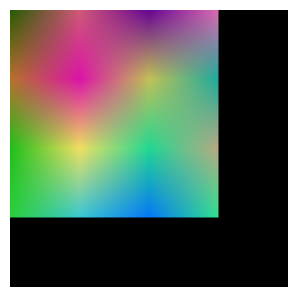

In [124]:
bicubic_resized = bicubic_interpolation(img, scale_factor)
bicubic_resized_low = bicubic_interpolation(img, scale_factor_low)

show_image(img, dpi)
show_image(bicubic_resized, dpi)

**СРАВНЕНИЕ**

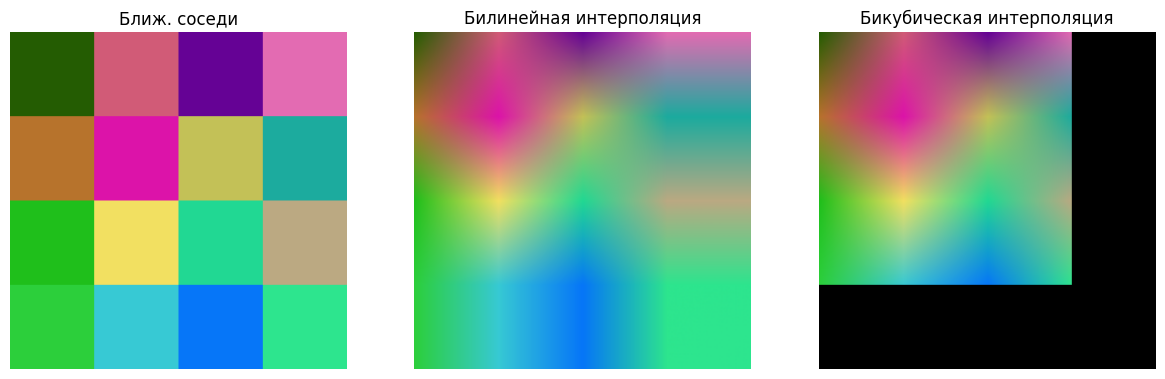

In [125]:
plt.figure(figsize=(20, 10))
plt.subplot(141), plt.imshow(nearest_resized), plt.axis('off'), plt.title('Ближ. соседи')
plt.subplot(142), plt.imshow(bilinear_resized), plt.axis('off'), plt.title('Билинейная интерполяция')
plt.subplot(143), plt.imshow(bicubic_resized), plt.axis('off'), plt.title('Бикубическая интерполяция')
plt.show()

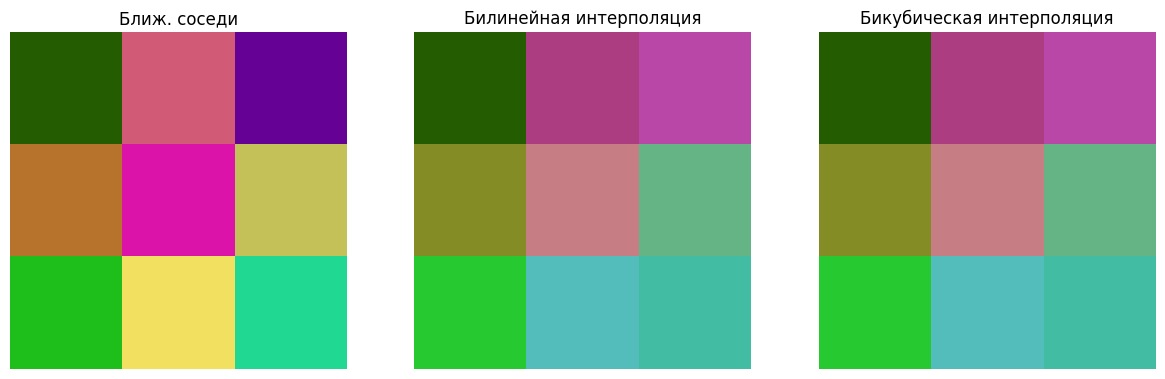

In [126]:
plt.figure(figsize=(20, 10))
plt.subplot(141), plt.imshow(nearest_resized_low), plt.axis('off'), plt.title('Ближ. соседи')
plt.subplot(142), plt.imshow(bilinear_resized_low), plt.axis('off'), plt.title('Билинейная интерполяция')
plt.subplot(143), plt.imshow(bicubic_resized_low), plt.axis('off'), plt.title('Бикубическая интерполяция')
plt.show()